# Simulation of Prosumers in a Shapley Coalition Utilizing NRG-X-Change Market

## Description:

Given a network of prosumers (residential consumers with generation capability) a dynamic market can be created that would pay out each prosumer according to its generation and the demand required at any moment in time. The NRG-X-Change market payment and charge functions are used to determine the prosumer revenue throughout a simulated timeframe. The prosumers are simulated to have volatility and resemble real world load and solar generaiton conditions. 

1. Gather Prosumer Data
2. Model NRG-X-Change Market for Prosumers 
3. Apply Cooperative Game Theory to Prosumers in a NRG-X-Change Market


## 1. Gather Prosumer Data

The data gathered is from EIA.gov. The data was then used to synthesize typical prosumer consumption and generation over the course of 12 months. Volatitlity in the usage and generation was added as a normal distribution with a given variance to simulate real world conditions. The data is pulled from a local file and then sorted by timestamp. The fields are grouped by id and by time. Grouping by time allows for settlement calculations to occur at each time interval.


In [25]:
import pandas as pd
import os
import pathlib
from datetime import datetime
#Import the data from local csv
def get_data(path):
    df = pd.read_csv(path) 
    df["time"] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M')
    df.sort_values(by='time')
    first_col = df.pop('id')
    df.insert(0, 'id', first_col)
    return df

all_prosumers_data = get_data('data/prosumer_N3_model_20210129_1416.csv') 
prosumer_data_by_id = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('id', as_index=False)]
N=len(prosumer_data_by_id)
prosumers_at_t = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('time', as_index=False)]
#Sample of Data
from IPython.display import HTML
HTML(prosumers_at_t[0].to_html(index=False))


id,time,demand,generation,consumption,net_energy,price
1,2019-10-01,785.747309,567.176089,218.571220,0.000000,11.66
2,2019-10-01,706.638381,897.462539,0.000000,-190.824158,11.66
3,2019-10-01,996.729985,392.570712,604.159273,0.000000,11.66


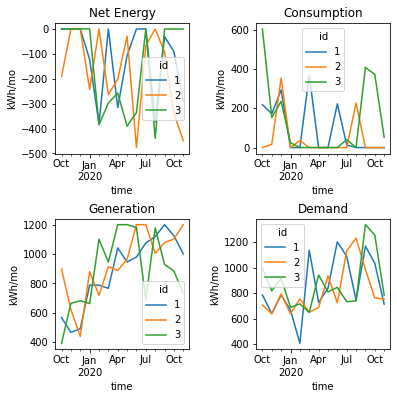

In [26]:
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(6, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
all_prosumers_data.pivot(index='time', columns='id', values='net_energy').plot(ax=axes[0, 0])
axes[0, 0].set_title("Net Energy")
axes[0, 0].set_ylabel("kWh/mo")
all_prosumers_data.pivot(index='time', columns='id', values='consumption').plot(ax=axes[0, 1])
axes[0, 1].set_title("Consumption")
axes[0, 1].set_ylabel("kWh/mo")
all_prosumers_data.pivot(index='time', columns='id', values='generation').plot(ax=axes[1, 0])
axes[1, 0].set_title("Generation")
axes[1, 0].set_ylabel("kWh/mo")
all_prosumers_data.pivot(index='time', columns='id', values='demand').plot(ax=axes[1, 1])
axes[1, 1].set_title("Demand")
axes[1, 1].set_ylabel("kWh/mo")
plt.show()

## 2. Model NRG-X-Change Market for Prosumers 


**What is NRG-X-Change?**
"In  this  paper  we  propose  NRG-X-Change  —  anovel mechanism for trading of locally produced re-newable energy that does not rely on an energy mar-ket or matching of orders ahead of time. In our modellocally produced energy is continuously fed into thegrid and payment is received based on actual usage,rather than predicted, as consumption is measured bythe DSO (Distribution Service Operator) and billed in near real-time." (Mihail Mihaylov)

### Modeling a Prosumer Market

We will leverage an NRGX-Change based market of prosumers on an micro-grid. Any excess energy that is not consumed by the micro-grid is not considered at this time. The goal of each prosumer would be to offset the demand of the micro-grid. In most cases the total demand would need to be supplemented by the larger Grid at some retail electricity price. The network will use the payout and consumption functions for NRGX-Change as each prosumer generates every month. 

The prosumers (P) are indicated on the diagram as generators of electricity. In this scenario solar PV is shown as a generation source. The Distribution Service Operator (DSO) is in charge of consuming excess Net Energy that is generated by the prosumer and it is not consumed by the prosumer. A consumer (C) is the term for a residence that has to consumer more energy that it can produce. It will need to pay for electricity and the DSO would charge it at some price. The NRG-X-Change function will charge the consumer and pay the prosumer for electricity consumed or generated.

<img src="img/prosumer_network_model.png" alt="prosumer_network_model" style="width: 200px;" align="center"/>



    

### Prosumer Payment Function 

The NRG-X-Change as described by the authors performs a dynamic payment to prosumers that are capable of meeting the demand of the micro-grid. The micro-grid is made of prosumers and consumers. As the load demand spikes the pricing for net generation also spikes to meet the demand. When there is too much generation on the grid the pricing drops encouraging prosumers to generate less and consumer to consume more. The payout function g(.) , utilizes a normalization component in the denominator to account for over or under generation distributing the payout along the curve. The payment is at its highest when generation meets the total demand and at its lowest as generation starts to saturate the market because of low demand. 

$$ g(x,t_p,t_c) = \frac{​​x^n* q_{t_p=t_c}​​}{e^{\frac{(t_p - t_c)^2}{a}}} $$

In [27]:
import math
import os
from functools import reduce

# NRGXChange Payment g(.) Function
def g(price,p,tp,tc,a,n):
    x = p
    q = (0.01*price)
    try:
        #print(f"n{n},tp{tp},tc{tc},a{a},q{q}")
        pay = abs((pow(x,n)*q)/math.exp(pow((tp-tc),2)/a))
    except OverflowError:
        pay = float('inf')
    return pay

### Consumer Charge/Cost Function

Where $x$, is the net energy of the prosumer. $q$, is the maximum price allowed. $t_p$ ,is the total produced energy of all prosumers. $t_c$ is the total consumption of all the prosumers. $a$ , is a scaling constant to adjust the pay out. Similarly lets consider the cost of energy for consumers to purchase based on pricing set by the h(.) function. In tandem these incentives are non-linear because of the distribution curve. The shape of that curve can be adjusted to the size of the network and the volatility of the network.

$$ h(y,t_p,t_c) = \frac{y*r_{t_c>>t_p}​*t_c​}{t_c+t_p} $$

Where $y$ is the withdrawn energy, and $r_{t_c>>t_p}​$ is the maximum cost of energy delivered by the utility when the energy supply by prosumers is low. Again, $t_p$ is the total production and $t_c$ is the total consumption of the prosumers in the network. The minimum payment by the utility in the historical payment prices would indicate the minimum amount willing to charge customers for energy in order to cover the cost of delivering the energy. We will use the minimum price in our list for $r$.


In [28]:
# NRGXChange Charge h(.) Function
def h(price,c,tp,tc):
    y = c
    r = (0.01*price)
    try:
        cost = (y*r*tc)/(tc+tp)
    except OverflowError:
        cost = float('inf')
    return cost

### Apply NRGX-Change Settlement
There are lower layers to the actual movement of electricity between the prosumers and the DSO. We will stay at the financial transaction layer and not consider the interconnection, blockchain transactions and controls at this time. The financial transactions for net energy produced by prosumers is used in the payment function along with the net energy procued by other prosumers. If the demand for energy was great at that time and other prosumers where not filling in for the need then the price for the energy contributed goes up. This scheme relies on each prosumer not coordinating with others. Over-producing in this market will lead to lesser payment. By producing the exact amount that is needed then the payment is maximized. 

Lets apply the payment functions and determine the profits of each prosumer accordingly. 

1. Determine the max/min pricing to set the max/min pricing limits for the payout/cost functions. These limits are addresing the total payment allowed for prosumers and the minimum payment needed to deliver power, respectively.




In [29]:
#historical pricing 
max_price = all_prosumers_data['price'].max()
min_price = all_prosumers_data['price'].min()

2. Calculate the $t_c$ total consumption and $t_p$ total production of the set of prosumers.

3. Apply g(.) to any prosumer who is providing net_energy in order to calculate the payout for the net energy.

4. Apply h(.) to any prosumer that has not covered their own consumption needs and needs to buy the energy from the NRGX-Changes Market's DSO who would then use that demand. When consumption is high the pricing function for net energy pay out is automatically higher, and the cost for hte consumption is automatically higher.

In [30]:
#calculate the payment at time t, for all prosumers
def get_nrg_payments(df_by_t,max_price,min_price,a=0):
    if a==0:
        a = 100000 #default the a scaler
    for t in df_by_t:
        tc = t['consumption'].sum()
        tp = abs(t['net_energy']).sum()
        t['prosumer_credit'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=1,a=a) if abs(x) > 0 else 0)
        t['prosumer_debit'] = t['consumption'].apply(lambda x: -(h(price=min_price,c=x,tc=tc,tp=tp)) if abs(x) > 0 else 0) 
        #print(f"tc={tc},tp={tp}")
        t['prosumer_revenue'] = t['prosumer_credit'] + t['prosumer_debit']

    return df_by_t

prosumers_at_t = get_nrg_payments(prosumers_at_t,max_price,min_price)


The results of paying each prosumer based on the NRG-X-Change mechanism are now stored in a new column ('nrg_cash') . Notice that the payment amount is only applied when net generation is greater than 0 for each prosumer. It is also taking into account the total consumption at that time when calculating the payment. The more generation matching the demand the higher the payout.

In [31]:
#view the sample of data at time 0
df = prosumers_at_t[0]
first_col = df.pop('id')
df.insert(0, 'id', first_col)
from IPython.display import HTML
HTML(df.to_html(index=False))

id,time,demand,generation,consumption,net_energy,price,prosumer_credit,prosumer_debit,prosumer_revenue
1,2019-10-01,785.747309,567.176089,218.571220,0.000000,11.66,0.000000,-17.458161,-17.458161
2,2019-10-01,706.638381,897.462539,0.000000,-190.824158,11.66,0.425498,0.000000,0.425498
3,2019-10-01,996.729985,392.570712,604.159273,0.000000,11.66,0.000000,-48.256628,-48.256628


### Review of Market Payment
By grouping the dataset by timestamp we can sum up the total production and consumption and view how the NRG-X-Change mechanisim awards based on the deviations from the $t_c$ and $t_p$ , as stated previously.


In [32]:
import matplotlib.pyplot as plt
df = pd.concat(prosumers_at_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df

,demand,generation,consumption,net_energy,prosumer_credit,prosumer_debit,prosumer_revenue
time,,,,,,,
2019-10-01,2489.115675,1857.209340,822.730493,-190.824158,0.425498,-65.714789,-65.289291
2019-11-01,2095.158741,1752.771837,342.386903,0.000000,0.000000,-33.690871,-33.690871
2019-12-01,2496.569362,1613.011784,883.557578,0.000000,0.000000,-86.942066,-86.942066
2020-01-01,1991.844893,2331.807077,24.752677,-364.714861,13.881839,-0.154799,13.727040
2020-02-01,1876.720558,2607.386777,35.974998,-766.641217,0.445079,-0.158668,0.286411
2020-03-01,2435.570622,2626.448168,369.801664,-560.679210,47.087851,-14.461901,32.625950
2020-04-01,2355.176926,3130.190997,0.000000,-775.014071,0.230760,0.000000,0.230760
2020-05-01,2583.883075,3110.204309,0.000000,-526.321234,3.986764,0.000000,3.986764
2020-06-01,2772.057531,3360.999257,222.940101,-811.881827,3.058852,-4.726132,-1.667280


#### Analyzing 3 Prosumers

An analysis of the collective positive and negative cashflow of the prosumers is shown in the following plot as color. The size of each point indicates the amount of cash and the axis represent the relationship between the total consumption of the group and the total production of the group. Each sample indicates a single point in time, where in this study it ranges for 14 consecutive months. 

The plot shows that the highest payment is when generation and consumption are roughly the same (~400-500kWh). The NRG-X-Changes tries to benefit prosumers in this way to keep the generation balanced with consumption. Also note that the consumption is penalized the required consumption comes from the grid.


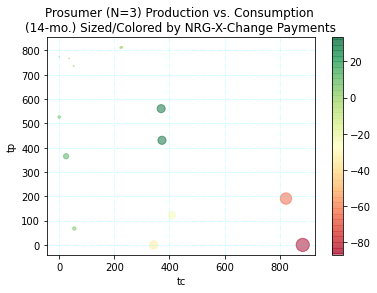

In [33]:
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
df['net_nrg_rev'] = df['prosumer_revenue'].apply(lambda x: x if x >= 0 else abs(x))
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=df['net_nrg_rev']*2,ax=ax ,alpha=0.5, c= df['prosumer_revenue'], cmap='RdYlGn')
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.title("Prosumer (N=3) Production vs. Consumption \n(14-mo.) Sized/Colored by NRG-X-Change Payments")
plt.show()

#### Analyzing a N=100 Prosumer Dataset with Tier1 capacity

The "N=100 Tier1" dataset is uniquely created and is not the same as the "N=3 Tier1" datasets shown above.
As we increase the market size we see that the average net generation is not enough to handle the overwhelming need as the network is increased. There is never enough generationf for incentives to matter in this case. The recommendation here would be to increase the overall capacity of the network to handle the load demand. 

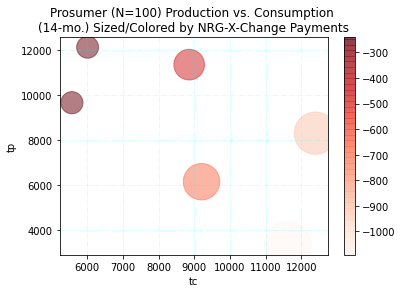

In [34]:
prosumers_data_n100 = get_data('data/prosumer_N100_model_20210129_1414.csv') 
prosumers_n100_at_t = [pd.DataFrame(y) for x, y in prosumers_data_n100.groupby('time', as_index=False)]
max_price = prosumers_data_n100['price'].max()
min_price = prosumers_data_n100['price'].min()
prosumers_n100_at_t = get_nrg_payments(prosumers_n100_at_t,min_price,max_price)
df = pd.concat(prosumers_n100_at_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
df['net_nrg_cash'] = df['prosumer_revenue'].apply(lambda x: x if x >= 0 else abs(x))
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=df['net_nrg_cash']*2,ax=ax ,alpha=0.5, c=df['prosumer_revenue'], cmap='Reds')
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.title("Prosumer (N=100) Production vs. Consumption \n(14-mo.) Sized/Colored by NRG-X-Change Payments")
plt.show()

#### Analyzing a N=100 Prosumer Dataset with Tier2 (100kW) capacity

The "N=100 Tier2" dataset is uniquely created and is not the same as the "N=3 Tier1" or the "N=100 Tier1" datasets shown above. The total generation outweighs the total consumption on the network. 

Should the graph be changed to total demand? instead of consumption?


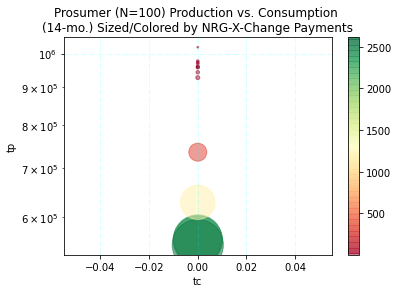

In [35]:
prosumers_data_n100_T2 = get_data('data/prosumer_N100_T2_model_20210221_1454.csv') 
prosumers_n100_T2_at_t = [pd.DataFrame(y) for x, y in prosumers_data_n100_T2.groupby('time', as_index=False)]
max_price = prosumers_data_n100_T2['price'].max()
min_price = prosumers_data_n100_T2['price'].min()
prosumers_n100_T2_at_t = get_nrg_payments(prosumers_n100_T2_at_t,min_price,max_price,a=100000000000)
#print(prosumers_n100_T2_at_t[0])
df = pd.concat(prosumers_n100_T2_at_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
df['net_nrg_cash'] = df['prosumer_revenue'].apply(lambda x: x if x >= 0 else abs(x))
fig, ax = plt.subplots()
ax = df.plot(kind='scatter', y='tp', x='tc',s=df['net_nrg_cash'],ax=ax ,alpha=0.5, c=df['prosumer_revenue'], cmap='RdYlGn')
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.title("Prosumer (N=100) Production vs. Consumption \n(14-mo.) Sized/Colored by NRG-X-Change Payments")
ax.set_yscale('log')
plt.show()

## 3. Apply Cooperative Game Theory to Prosumers in a NRG-X-Change Market

### 3.1 Review of Game Theory and Shapley Value

The game is in terms of a **characteristic function**, which specfies for every group of players the total payoff that the members of S can by signing an greement among themselves; this payoff is available for distribution among the members of the group. A coalitional game with transferable payoff is a pair $<N,v>$ where $N=\{1,...,n\}$ is the set of players and for every subset S of I (called a coalition) $v(S) \in \mathbb{R} $ is the total payoff that is available for division among members of S (called the worth of S). We assume that the larger the coalition the larger the payoff (this property is called superadditivity).

An agreement amongst players is a list $(x_1,x_1,...,x_n)$  where $x_1,$ is the proposed payoff to individual i. Shapley value is interpreted in terms of **expected marginal contribution**. It is calculated by considering all the possible orders of arrival of the players into a room and giving each player his marginal contribution. 


### Example 1. : Calculate Shapley Value of 2 Prosumers 

Assume there are two players that are prosumers on a micro-grid. The prosumers contribute to the micro-grid in order to meet the demand of a consumer on the grid. In this example the consumer is not treated as a player. The prosumers can supply the demand in the two different ways based on order of arrival. 

1. Prosumer 1 can supply a partial amount of the demand first and then Prosumer 2 can supply the rest.  
2. Prosumer 2 can supply a partial amount of the demand first and then Prosumer 1 can supply the rest.

If the consumer payment is not linear but increases the more the total demand is met then there is an incentive for the generation to be completely filled to get back more money for it. That means that as the generation nears 100% of the demand the pricing will be more therefore the combination of the two prosumers generation becomes a superadditive payout.

Let's choose a moment in time that the consumer is demanding energy to be placed on the micro-grid. At that moment, Prosumer 1, would only be able to fulfill 75% of the request and would be paid at the going price times the max amount provided, $v({1})= 0.77$. Prosumer 2, would only be able to fulfill 50% of the demand (less effecient generation), it would also be paid at the going price times the max amount of energy provided,$v({1})= 0.51$. If the complete demand is met then the payout would be $v({12})= 1.04$, where the notation for contributions of both is interchangeable since it results in the same total payout, i.e. $v({12}) == v({21})$

Consider Prosumer 1 fulfills the demand at 75%, and Prosumer 2 fulfills the demand at 25% (with a surples of 25%), compared to Prosumer 2 fulfilling 50% of the demand and then Prosumer 1 fulfilling the remaining 50% (with a surplus of 25%). The marginal contribution of each player can be different depending on how much they have to provide. Since the one that can provide the most can capture more of the superadditive pricing then the one who cannot provide the most would not be subject to the same superadditive pricing and needs to be paid according to its capacity to contribute to the overall worth of the coalition. 

If Prosumer 1 contributes first then Prosumer 2, Prosumer 1's contribution is $v({1})= 0.77 $ when Prosumer 2 arrives the surplus increases from 0.77 to 1.04 and therefore Prosumer 2's marginal contribution is $v({2}) = v({12})-v({1})$ ,  $ 0.27 = 1.04-0.77$.

If Prosumer 2 contributes first then Prosumer 1, Prosumer 2's contribution is $v({2})= 0.51 $ when Prosumer 1 arrives the surplus increases from 0.51 to 1.04 and therefore Prosumer 1's marginal contribution is $v({1}) = v({12})-v({2})$ ,  $ 0.53 = 1.04-0.51$.

---
| Probability 	|  Order of Arrival |  P1 M.C.  |  P2 M.C.  |  
|:-------------:|:----------------:|:------------:|:------------:|
| 1/2         	| First 1 then 2  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | 0.77 &nbsp;&nbsp;&nbsp;&nbsp; | 0.27 &nbsp;&nbsp;&nbsp;&nbsp; |
| 1/2         	| First 2 then 1  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | 0.53 &nbsp;&nbsp;&nbsp;&nbsp; | 0.51 &nbsp;&nbsp;&nbsp;&nbsp; |
---
#### Expected Marginal Contribution (Shapley Value Calculation)
|P1 Shapley|  P2 Shapley|
|:------------:|:------------:
|$\frac{1}{2} *  0.77 + \frac{1}{2} * 0.53$ = 0.65   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|    $\frac{1}{2} * 0.27 + \frac{1}{2} * 0.51$ = 0.39 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |
---



#### Example 1 Results 
In conclusion, if Prosumer 1 and Prosumer 2 have the capacity to fulfill the need of the demand at a given moment in time, they can either request individually to supplement the need and recieve individual payment based on what they offer or join in a coalition to supplement more of the demand together and get paid through marginal contributions.

#### Example 1 Follow-up : What Happens to Excess Energy?
Prosumers are generating energy for the demand but the joined contribution to the demand of multiple prosumers can become a surplus to the demand requested. At the point that the net energy is more than the demand it must be dissipated or "curtailed". In the example prosumers would first find consensus on contributing a given amount based on its overall capacity then a setpoint would allow the prosumers to feed the power based on the agreed setpoint. The curtailment of the delivered energy can be done in a system that converts DC to AC and limits the injection of power to the Grid. The curtailment would shed the excess energy, by limiting or temporarily disconnecting the solar panels. Another option would be to store the excess energy into battery or hydrogen storage to be retrieved later. This scenario is not explored in this study but can provide additional benefits. 

### 3.2 Programatically Calculate Shapley Value

We can model the a shapley value calculation based on the number of players and the marginal contribution logic described in the previous example. Each players characteristic function will determine the players max contribution. The order of arrival for each player is a combinatorial assesment based on number of players , $N$ . The probability of each combination is $1/N!$. The probability will be multiplied by the marginal contribution of each player for every combination of the other players order of arrival. It will then be summed up for that player. The final result would be the calcualted shapley value for the player. The function below recieves a list of the players characteristic function output and the number of players in order to return the shapley values. 

In [36]:
# Shapley Value Python Logic 
# Authored by Susobhan Ghosh
# https://github.com/susobhang70
# Committed on 02/01/2020
from itertools import combinations
import bisect
#Create Combinatorial from List
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
    return PS
#Calculate Shapley from Characteristic Value list
def get_shapley(n,v):
    tempList = list([i for i in range(n)]) 
    N = power_set(tempList)
    shapley_values = []
    for i in range(n):
        shapley = 0
        for j in N:
            if i not in j:
                cmod = len(j)
                Cui = j[:]
                bisect.insort_left(Cui,i)
                l = N.index(j)
                k = N.index(Cui)
                temp = float(float(v[k]) - float(v[l])) *\
                           float(math.factorial(cmod) * math.factorial(n - cmod - 1)) / float(math.factorial(n))
                shapley += temp
        cmod = 0
        Cui = [i]
        k = N.index(Cui)
        temp = float(v[k]) * float(math.factorial(cmod) * math.factorial(n - cmod - 1)) / float(math.factorial(n))
        shapley += temp
        shapley_values.append(shapley)
    return shapley_values
   

#### Validating Programatic Calculation of Shapley Value

Lets test the shapley function by leveraging our previous example. The number of players is $n=2$ and the characterstic input that we used in the example is $ v = [v({1}),v({2}),v({1,2})], v = [0.10,0.12,0.23]$. Note that the result of the scripted function matches the example provided in the text. We can now use it for more than 2 players and still calculate the shapley values accurately. 



In [37]:
#Test of Example 1
# Results in Shapley distribution of : Prosumer-1: $0.65, Prosumer-2: $0.39
n=2
v=[0.77,0.51,1.04]
vals = get_shapley(n,v)
print(f"Prosumer-1: ${vals[0]}, Prosumer-2: ${vals[1]}")

Prosumer-1: $0.65, Prosumer-2: $0.39


### 3.3 Create Prosumer Coalitions (N=3)

At every settlement period (monthly) we will determine if more than one prosumer is providing net_energy to the grid. If there is a situation like that then the group of prosumers can participate in a coalitional payout instead of just the NRGX-change payout. The idea would be that the NRGX-Change will see two prosumers as a single prosumer instead of two individuals. We would need to modify the dataset to combine prosumers at the times that more than one is generating. Then we could re-apply NRG payouts and use the marginal contribution to determine the benefit of coalitional payout. 


In [38]:
prosumers_data_n3 = get_data('data/prosumer_N3_model_20210129_1416.csv') 
max_price = prosumers_data_n3['price'].max()
min_price = prosumers_data_n3['price'].min()
prosumers_n3_at_t = [pd.DataFrame(y) for x, y in prosumers_data_n3.groupby('time', as_index=False)]

for t in prosumers_n3_at_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=100000
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n3_at_t[0].to_html(index=False))


id,time,demand,generation,consumption,net_energy,price,nrg_v
1,2019-10-01,785.747309,567.176089,218.571220,0.000000,11.66,0.000000
2,2019-10-01,706.638381,897.462539,0.000000,-190.824158,11.66,0.425498
3,2019-10-01,996.729985,392.570712,604.159273,0.000000,11.66,0.000000


#### 3.3.1 Pay Consumers for Revenue Using NRG-X-Change
At each time $t$ we will group the prosumers that are generating then we will take the total consumption at that time to then submit it for NRG-X-change payment. The returned payment will then be distributed using a shapley value calculation instead of a normal split between each prosumer. The idea is to pay the prosumers for contributions as if they are part of a coalition and will be repaid fairly at each transactional time period. 



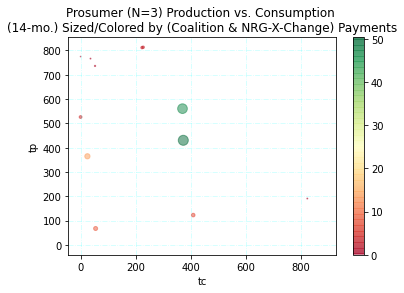

In [39]:
df = pd.concat(prosumers_n3_at_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
df['net_nrg_cash'] = df['nrg_v'].apply(lambda x: x if x >= 0 else abs(x))
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=df['net_nrg_cash']*2,ax=ax ,alpha=0.5, c= df['nrg_v'], cmap='RdYlGn')
plt.title("Prosumer (N=3) Production vs. Consumption \n(14-mo.) Sized/Colored by (Coalition & NRG-X-Change) Payments")
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.show()

In [40]:
for t in prosumers_n3_at_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=100000
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n3_at_t[3].to_html(index=False))

id,time,demand,generation,consumption,net_energy,price,nrg_v
1,2020-01-01,666.182080,788.227717,0.000000,-122.045637,11.73,4.645322
2,2020-01-01,637.803627,880.472852,0.000000,-242.669225,11.73,9.236517
3,2020-01-01,687.859185,663.106509,24.752677,0.000000,11.73,0.000000


In [41]:
#calculate coalitional payout each time step of t
for t in prosumers_n3_at_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    a=100000
    #identify number of prosumers at every time step of t, that have provided net_energy > 0
    ids_net_energy_given = t[abs(t['net_energy']) > 0]['id']
    N_c=len(ids_net_energy_given)
    #sum the absolute value of all the net energy given by the indentified IDs
    #abs(t.loc[t['id'].isin(ids_net_energy_given)]['net_energy']).sum()
    t['coalition_v'] = 0
    if N_c == 1:
        t['coalition_v'] = t['nrg_v']
    if N_c > 1:
        List = ids_net_energy_given
        PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
        char_vals = []
        for n in PS:
            #locate all ids in time step within the powerset, (factorial), and sum up
            contribution = abs(t.loc[t['id'].isin(n)]['net_energy']).sum()
            char_func_val = g(price=max_price,p=contribution,tc=tc,tp=tp,n=1,a=a) 
            char_vals.append(char_func_val)
        #print(PS)
        #print(char_vals)
        shapleys = get_shapley(N_c,char_vals)
        for i in range(N_c):
            t.loc[t.index[ids_net_energy_given.values[i]-1], 'coalition_v'] = shapleys[i]

#Sample of Data
from IPython.display import HTML
HTML(prosumers_n3_at_t[3].to_html(index=False))

result = pd.concat(prosumers_n3_at_t)
HTML(result.to_html(index=False))

[[1], [2], [1, 2]]
[4.645321820305046, 9.236517392767565, 13.881839213072613]
[[1], [3], [1, 3]]
[0.2217880276870404, 0.22329081265113426, 0.44507884033817463]
[[2], [3], [2, 3]]
[22.1321365281624, 24.9557144544123, 47.0878509825747]
[[1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]]
[0.09402541918940416, 0.05998907649654288, 0.07674518943839763, 0.15401449568594702, 0.17077060862780175, 0.1367342659349405, 0.23075968512434467]
[[1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]]
[0.808205246824032, 0.22007501515322325, 2.958483435518151, 1.0282802619772553, 3.766688682342183, 3.1785584506713747, 3.9867636974954066]
[[2], [3], [2, 3]]
[1.794892441495276, 1.26395962349964, 3.0588520649949165]
[[1], [3], [1, 3]]
[1.4517821523948917, 1.7095121254583554, 3.161294277853247]
[[1], [2], [1, 2]]
[1.6273820459623738, 4.922856083631041, 6.550238129593415]
[[1], [2], [1, 2]]
[10.591346872324742, 39.74432020363901, 50.335667075963755]
[[1], [2], [1, 2]]
[0.32353341267794883, 0.5038902785443123, 0.82

id,time,demand,generation,consumption,net_energy,price,nrg_v,coalition_v
1,2019-10-01,785.747309,567.176089,218.571220,0.000000,11.66,0.000000,0.000000
2,2019-10-01,706.638381,897.462539,0.000000,-190.824158,11.66,0.425498,0.425498
3,2019-10-01,996.729985,392.570712,604.159273,0.000000,11.66,0.000000,0.000000
1,2019-11-01,638.907999,466.653885,172.254114,0.000000,12.09,0.000000,0.000000
2,2019-11-01,638.090831,621.538424,16.552407,0.000000,12.09,0.000000,0.000000
3,2019-11-01,818.159911,664.579529,153.580382,0.000000,12.09,0.000000,0.000000
1,2019-12-01,785.346708,491.636087,293.710621,0.000000,11.62,0.000000,0.000000
2,2019-12-01,793.764068,439.250888,354.513179,0.000000,11.62,0.000000,0.000000
3,2019-12-01,917.458586,682.124809,235.333777,0.000000,11.62,0.000000,0.000000
1,2020-01-01,666.182080,788.227717,0.000000,-122.045637,11.73,4.645322,4.645322


### 3.4 Create Prosumer Coalitions (N=100)
At every settlement period (monthly) we will determine if more than one prosumer is providing net_energy to the grid. If there is a situation like that then the group of prosumers can participate in a coalitional payout instead of just the NRGX-change payout. The idea would be that the NRGX-Change will see two prosumers as a single prosumer instead of two individuals. We would need to modify the dataset to combine prosumers at the times that more than one is generating. Then we could re-apply NRG payouts and use the marginal contribution to determine the benefit of coalitional payout.

In [42]:
prosumers_data_n100 = get_data('data/prosumer_N100_model_20210129_1414.csv') 
max_price = prosumers_data_n100['price'].max()
min_price = prosumers_data_n100['price'].min()
prosumers_n100_at_t = [pd.DataFrame(y) for x, y in prosumers_data_n100.groupby('time', as_index=False)]

for t in prosumers_n100_at_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=100000000000
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n100_at_t[0].to_html(index=False))

id,time,demand,generation,consumption,net_energy,price,nrg_v
1,2019-10-01,887.985834,719.246104,168.739730,0.000000,11.66,0.000000
2,2019-10-01,1034.704050,593.269981,441.434068,0.000000,11.66,0.000000
3,2019-10-01,874.517351,622.686223,251.831128,0.000000,11.66,0.000000
4,2019-10-01,1088.024347,680.854226,407.170120,0.000000,11.66,0.000000
5,2019-10-01,642.372765,594.783219,47.589546,0.000000,11.66,0.000000
6,2019-10-01,682.105032,524.486440,157.618592,0.000000,11.66,0.000000
7,2019-10-01,793.283632,716.109846,77.173786,0.000000,11.66,0.000000
8,2019-10-01,790.984818,741.363574,49.621244,0.000000,11.66,0.000000
9,2019-10-01,853.910359,617.902108,236.008251,0.000000,11.66,0.000000
10,2019-10-01,704.532870,609.900624,94.632245,0.000000,11.66,0.000000


#### 3.4.1 Pay Consumers for Revenue Using NRG-X-Change
At each time  
t
  we will group the prosumers that are generating then we will take the total consumption at that time to then submit it for NRG-X-change payment. The returned payment will then be distributed using a shapley value calculation instead of a normal split between each prosumer. The idea is to pay the prosumers for contributions as if they are part of a coalition and will be repaid fairly at each transactional time period.

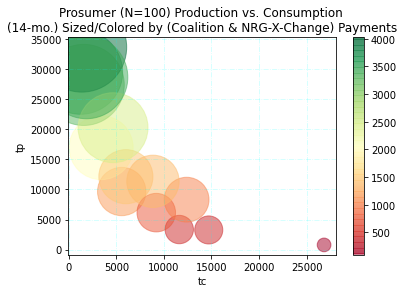

In [43]:
df = pd.concat(prosumers_n100_at_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
df['net_nrg_cash'] = df['nrg_v'].apply(lambda x: x if x >= 0 else abs(x))
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=df['net_nrg_cash']*2,ax=ax ,alpha=0.5, c= df['nrg_v'], cmap='RdYlGn')
plt.title("Prosumer (N=100) Production vs. Consumption \n(14-mo.) Sized/Colored by (Coalition & NRG-X-Change) Payments")
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.show()

In [44]:
for t in prosumers_n100_at_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=100000000000
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n100_at_t[3].to_html(index=False))

id,time,demand,generation,consumption,net_energy,price,nrg_v
1,2020-01-01,696.291964,652.057768,44.234197,0.000000,11.73,0.000000
2,2020-01-01,586.926927,629.018467,0.000000,-42.091540,11.73,5.088017
3,2020-01-01,568.573757,691.777596,0.000000,-123.203839,11.73,14.892854
4,2020-01-01,568.856863,1017.843767,0.000000,-448.986904,11.73,54.273444
5,2020-01-01,577.265373,807.064828,0.000000,-229.799455,11.73,27.778110
6,2020-01-01,617.669995,678.485452,0.000000,-60.815458,11.73,7.351360
7,2020-01-01,871.082881,1098.317216,0.000000,-227.234334,11.73,27.468039
8,2020-01-01,652.059103,725.010112,0.000000,-72.951009,11.73,8.818303
9,2020-01-01,953.428183,702.220593,251.207590,0.000000,11.73,0.000000
10,2020-01-01,759.540344,721.436706,38.103638,0.000000,11.73,0.000000


In [21]:
#calculate coalitional payout each time step of t
for t in prosumers_n100_at_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    a=100000000000
    #identify number of prosumers at every time step of t, that have provided net_energy > 0
    ids_net_energy_given = t[abs(t['net_energy']) > 0]['id']
    N_c=len(ids_net_energy_given)
    #sum the absolute value of all the net energy given by the indentified IDs
    #abs(t.loc[t['id'].isin(ids_net_energy_given)]['net_energy']).sum()
    t['coalition_v'] = 0
    if N_c == 1:
        t['coalition_v'] = t['nrg_v']
    if N_c > 1:
        List = ids_net_energy_given
        PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
        char_vals = []
        for n in PS:
            #locate all ids in time step within the powerset, (factorial), and sum up
            contribution = abs(t.loc[t['id'].isin(n)]['net_energy']).sum()
            char_func_val = g(price=max_price,p=contribution,tc=tc,tp=tp,n=1,a=a) 
            char_vals.append(char_func_val)
        #print(PS)
        #print(char_vals)
        shapleys = get_shapley(N_c,char_vals)
        for i in range(N_c):
            t.loc[t.index[ids_net_energy_given.values[i]-1], 'coalition_v'] = shapleys[i]

#Sample of Data
from IPython.display import HTML
HTML(prosumers_n100_at_t[3].to_html(index=False))

result = pd.concat(prosumers_n100_at_t)
HTML(result.to_html(index=False))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-d85e1d1b346a>", line 25, in <module>
    shapleys = get_shapley(N_c,char_vals)
  File "<ipython-input-12-bf3939da8ad2>", line 24, in get_shapley
    k = N.index(Cui)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPyth

KeyboardInterrupt: 